Устанавливаем устройство для вычислений (GPU, если доступен, иначе CPU)

In [2]:
import torch
from torch import nn
import torch.optim as optim

import pickle

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

with open('/kaggle/input/legoclassification/lego-train.pickle', 'rb') as train_fh:
    train_data = pickle.load(train_fh)

with open('/kaggle/input/legoclassification/lego-test.pickle', 'rb') as test_fh:
    test_data = pickle.load(test_fh)

Using device: cpu


Извлекаем изображения и метки из наборов данных, а так же преобразовываем их в тензорные наборы 

In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

train_data_X = np.array([img for (img, _) in train_data])
train_data_y = np.array([lbl for (_, lbl) in train_data])

test_data_X = np.array([img for (img, _) in test_data])
test_data_y = np.array([lbl for (_, lbl) in test_data])

img_transforms = transforms.Compose([transforms.Normalize(0.13, 0.31)])

def get_dataset(X, y):
    tensor_x = torch.tensor(X, dtype=torch.float32)
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.tensor(y, dtype=torch.int64) 

    dataset = TensorDataset(tensor_x, tensor_y)
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)

Определяем названия для меток, а так же отобразим форму первого батча с именной меткой

Original shape is  torch.Size([48, 48, 1])


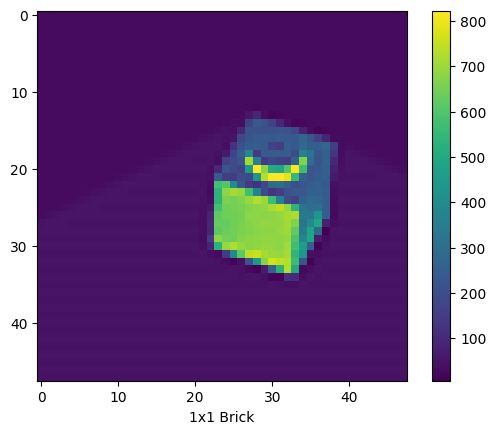

In [6]:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', 
               '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']

train_dataloader = DataLoader(train_dataset)
images_data, label_data = next(iter(train_dataloader)) 

print('Original shape is ', images_data[0].shape)

plt.figure()
plt.imshow(images_data[0].numpy().squeeze())
plt.colorbar()
plt.xlabel(class_names[label_data[0].item()])
plt.show()

Напишем функции для построения простой полносвязной NN с инициализацией весов по слоям, а так же для обучения нашей NN с отображением прогресса и сохранением истории точности по эпохам. После чего отобразим график точности

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=64, out_features=10, bias=True)
)


Training Progress: 100%|██████████| 1600/1600 [00:10<00:00, 159.59it/s, accuracy=0.827, epoch=199, loss=8.86]


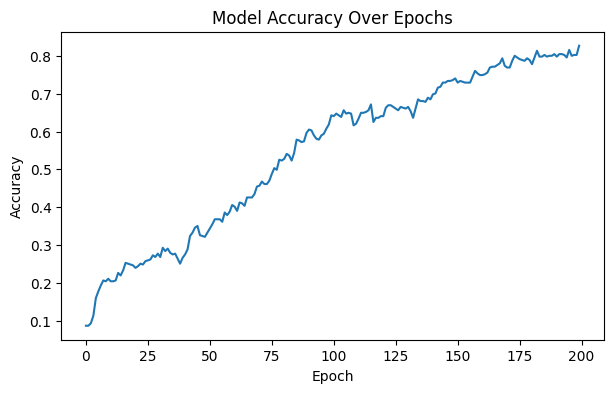

In [10]:
from tqdm import tqdm

def build_neural_network():
    def initialize_weights(layer):
        if isinstance(layer, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)
        
    model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(48 * 48, 128),
        torch.nn.Sigmoid(),
        torch.nn.Linear(128, 64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64, 10)
    )
    
    model.apply(initialize_weights)
    
    return model

def train_model(model, dataloader, device, epochs, learning_rate):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    accuracy_history = []

    with tqdm(total=len(dataloader) * epochs, desc="Training Progress", leave=True) as pbar:
        for epoch in range(epochs):
            total_loss = 0.0
            correct_preds, total_samples = 0, 0
            
            for inputs, labels in dataloader:
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, preds = outputs.max(1)
                correct_preds += preds.eq(labels).sum().item()
                total_samples += labels.size(0)

                batch_accuracy = correct_preds / total_samples
                pbar.set_postfix(epoch=epoch, loss=total_loss, accuracy=batch_accuracy)
                pbar.update()

            accuracy_history.append(correct_preds / total_samples)
        pbar.close()

    return accuracy_history

def plot_accuracy_history(history, title="Training Accuracy"):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

model = build_neural_network()
print(model)

BATCH_SIZE, EPOCHS, LEARNING_RATE = 64, 200, 0.001
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
accuracy_history = train_model(model, train_dataloader, device, EPOCHS, LEARNING_RATE)

plot_accuracy_history(accuracy_history, "Model Accuracy Over Epochs")

Далее определим функцию для построения сверточной NN для сравнения производительности и точности решения задачи классификации

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


Training Progress: 100%|██████████| 1600/1600 [00:43<00:00, 36.92it/s, accuracy=0.998, epoch=199, loss=5.23] 


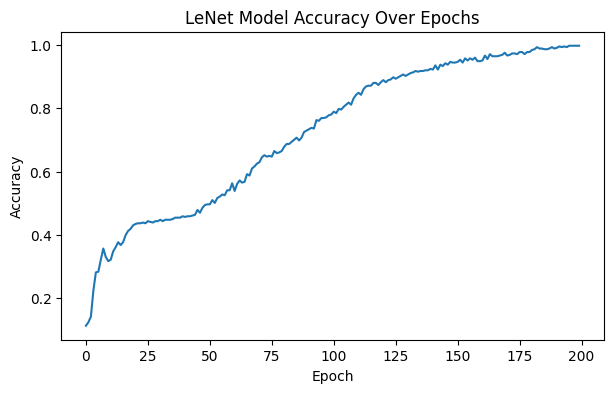

In [11]:
def build_lenet():
    def init_weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)
        elif isinstance(layer, nn.Conv2d):
            nn.init.xavier_uniform_(layer.weight)
        
    lenet_model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2),  # 48x48x6
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),       # 24x24x6
        nn.Conv2d(6, 16, kernel_size=5),             # 20x20x16
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),       # 10x10x16
        nn.Flatten(),
        nn.Linear(10*10*16, 120),
        nn.Sigmoid(),
        nn.Linear(120, 84),
        nn.Sigmoid(),
        nn.Linear(84, 10)
    )
  
    lenet_model.apply(init_weights)
    return lenet_model

lenet = build_lenet()
print(lenet)

history_lenet = train_model(lenet, train_dataloader, device, EPOCHS, LEARNING_RATE)
plot_accuracy_history(history_lenet, "LeNet Model Accuracy Over Epochs")

Исходя из результатов, можно сделать вывод, что сверточная NN, в частности LeNet, значительно превосходит полносвязную NN по точности для нашей задачи. Хотя понадобилось больше времени на обучение, сверточные модели чаще всего больше подходят для решения подобных задач.